In [171]:
import pandas as pd
import librosa
import os
import numpy as np
import re
from pydub import AudioSegment, effects
import noisereduce as nr
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [172]:
df = pd.read_csv('data/songs_wav.csv')

In [173]:
def sanitize_filename(filename):
    """
    Removes or replaces invalid characters from a filename or folder name.
    
    Args:
        filename (str): The original filename or folder name.
        
    Returns:
        str: The sanitized filename or folder name.
    """
    return re.sub(r'[<>:"/\\|?*]', '', filename)

def normalized_yt_title(title):
    """
    Normalizes a YouTube title by converting it to lowercase, replacing spaces with underscores,
    and removing non-alphanumeric characters except underscores.
    
    Args:
        title (str): The original title of the YouTube video.
        
    Returns:
        str: The normalized title.
    """
    text = title.lower()
    text = text.replace(' ', '_')
    text = re.sub(r'[^a-z0-9_]', '', text)
    text = re.sub(r'_{2,}', '_', text)
    
    return text

def remove_silence(audio, threshold=20):
    """
    Removes silent sections from an audio signal based on a decibel threshold.
    
    Args:
        audio (ndarray): The audio signal as a numpy array.
        threshold (int): The decibel threshold to trim silence. Defaults to 20.
        
    Returns:
        ndarray: The trimmed audio signal.
    """
    return librosa.effects.trim(audio, top_db=threshold)[0]

def normalize_audio(audio):
    """
    Normalizes the audio signal to a standard volume level.
    
    Args:
        audio (AudioSegment): The audio segment to normalize.
        
    Returns:
        AudioSegment: The normalized audio segment.
    """
    return effects.normalize(audio)

def noise_reduction(audio, noise_profile):
    """
    Reduces noise from an audio signal using a noise profile.
    
    Args:
        audio (ndarray): The audio signal as a numpy array.
        noise_profile (ndarray): The noise profile as a numpy array.
        
    Returns:
        ndarray: The noise-reduced audio signal.
    """
    return nr.reduce_noise(audio_clip=audio, noise_clip=noise_profile)

split_result = []

def split_songs_to_segments(df, output_base_folder='datasets/30s_segments'):
    """
    Splits songs into 30-second segments and saves them as individual files.
    
    Args:
        df (DataFrame): A pandas DataFrame containing song metadata with 'wav_path' and 'nama_lagu' columns.
        output_base_folder (str): The base folder to save the segments. Defaults to 'datasets/30s_segments'.
        
    Returns:
        None
    """
    for index, row in df.iterrows():
        wav_path = row['wav_path']
        nama_lagu = row['nama_lagu']
        
        os.makedirs(f"{output_base_folder}/{normalized_yt_title(nama_lagu)}", exist_ok=True)
        
        audio = AudioSegment.from_wav(wav_path)
        audio = audio.set_channels(1)
        
        audio = normalize_audio(audio)
        
        total_duration = len(audio) / 1000
        segment_duration = 30
        num_segments = int(total_duration // segment_duration)
        
        for i in range(num_segments):
            start_time = i * segment_duration * 1000 
            end_time = (i + 1) * segment_duration * 1000
            segment = audio[start_time:end_time]
            
            segment_file = f"{output_base_folder}/{normalized_yt_title(nama_lagu)}/segment_{index}_{i}.wav"
            segment.export(segment_file, format="wav")
            
            split_result.append({
                'title': nama_lagu,
                '30s_path': segment_file
            })
        print(f"Saved {num_segments} segments for {nama_lagu} at: {output_base_folder}/{normalized_yt_title(nama_lagu)}")

In [174]:
split_songs_to_segments(df)

Saved 9 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 5 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 8 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 10 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 4 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 5 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 9 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments fo

In [175]:
# save split result to csv
split_result_df = pd.DataFrame(split_result)
split_result_df.to_csv('data/30s_segments.csv', index=False)

In [176]:
df_res = pd.read_csv('data/30s_segments.csv')
df_res.head()

,title,30s_path
0,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_0.wav
1,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_1.wav
2,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_2.wav
3,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_3.wav
4,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_4.wav


### Data Augmentation

In [177]:
def noise(data):
    """
    Adds random noise to an audio signal to augment data.

    Args:
        data (ndarray): The audio signal as a numpy array.

    Returns:
        ndarray: The audio signal with added noise.
    """
    noise_amp = 0.05 * np.random.uniform() * np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=1.0):
    """
    Stretches or compresses the audio by a given rate.

    Args:
        data (ndarray): The audio signal as a numpy array.
        rate (float): The rate to stretch the audio. A value > 1 speeds it up, < 1 slows it down.

    Returns:
        ndarray: The time-stretched audio signal.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch_shift(data, sample_rate):
    """
    Shifts the pitch of an audio signal.

    Args:
        data (ndarray): The audio signal as a numpy array.
        sample_rate (int): The sampling rate of the audio signal.

    Returns:
        ndarray: The pitch-shifted audio signal.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                       sample_rate, n_steps=pitch_change, 
                                       bins_per_octave=bins_per_octave)
    return data

def speedNpitch(data):
    """
    Adjusts both the speed and pitch of an audio signal.

    Args:
        data (ndarray): The audio signal as a numpy array.

    Returns:
        ndarray: The audio signal with modified speed and pitch.
    """
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

def pad_or_truncate(data, length):
    """
    Pads or truncates an audio signal to the specified length.

    Args:
        data (ndarray): The audio signal as a numpy array.
        length (int): The desired length of the audio signal.

    Returns:
        ndarray: The audio signal padded or truncated to the specified length.
    """
    if len(data) > length:
        return data[:length]
    elif len(data) < length:
        return np.pad(data, (0, length - len(data)), 'constant')
    
    return data

### Feature Extraction

In [178]:
# extract the feature using mfcc
extract_res = []
def mfcc_features(data):
    """
    Extract MFCC (Mel-frequency cepstral coefficients) features from the dataset.

    Args:
        data (pandas.DataFrame): A DataFrame containing paths to audio files and their titles.

    Returns:
        list: A list of dictionaries with titles, paths, and extracted features.
    """
    try:
        for index, row in data.iterrows():
            audio, sample_rate = librosa.load(row['30s_path'])
            mfcc_def = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)

            augmentations = [
                lambda x: noise(x),
                lambda x: speedNpitch(x)
            ]

            extract_res.append({
                'title': row['title'],
                '30s_path': row['30s_path'],
                'features': mfcc_def
            })

            for aug in augmentations:
                augmented_data = aug(audio)
                mfccs = np.mean(librosa.feature.mfcc(y=augmented_data, sr=sample_rate, n_mfcc=40).T, axis=0)
                extract_res.append({
                    'title': row['title'],
                    '30s_path': row['30s_path'],
                    'features': mfccs
                })
        return extract_res
    except Exception as e:
        logging.error(f"Error {e} encountered while parsing file: {data['30s_path']}")
        return None 

def chroma_features(file_path):
    """
    Extract chroma features from an audio file.

    Args:
        file_path (str): Path to the audio file.

    Returns:
        numpy.ndarray: Processed chroma features.
    """
    try:
        audio, sample_rate = librosa.load(file_path) 
        chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
        chroma_processed = np.mean(chroma.T,axis=0)
    except Exception as e:
        logging.error(f"Error encountered while parsing file: {file_path}")
        return None 
     
    return chroma_processed

def mel_features(file_path):
    """
    Extract Mel-spectrogram features from an audio file.

    Args:
        file_path (str): Path to the audio file.

    Returns:
        numpy.ndarray: Processed Mel-spectrogram features.
    """
    try:
        audio, sample_rate = librosa.load(file_path) 
        mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
        mel_processed = np.mean(mel.T,axis=0)
    except Exception as e:
        logging.error(f"Error encountered while parsing file: {file_path}")
        return None 
     
    return mel_processed

def combined_features(file_path):
    """
    Combine MFCC and chroma features from an audio file.

    Args:
        file_path (str): Path to the audio file.

    Returns:
        numpy.ndarray: Concatenated features of MFCC and chroma.
    """
    mfcc = mfcc_features(file_path)
    chroma = chroma_features(file_path)
    # mel = mel_features(file_path)
    
    return np.concatenate((mfcc, chroma))

In [179]:
features = mfcc_features(df_res)
df_features = pd.DataFrame(features)

In [180]:
df_features.to_csv('data/30s_segments_features.csv', index=False)
df_features.head()

,title,30s_path,features
0,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_0.wav,"[-221.5486, 85.78904, 10.051114, 22.60556, 2.3..."
1,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_0.wav,"[-99.86517400377362, 35.19033425754519, 12.149..."
2,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_0.wav,"[-278.79803, 66.31924, 6.153332, 13.052689, 2...."
3,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_1.wav,"[-184.57425, 105.25339, 19.9047, 28.026234, 5...."
4,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_1.wav,"[-66.83097235049536, 41.21687147791448, 22.790..."


In [181]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def print_score(clf, X_train, y_train, X_test, y_test, train=True):    
    if train:
        pred = clf.predict(X_train)
        clf_report = classification_report(y_train, pred, zero_division=1)
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print(f"F1 Score: {f1_score(y_train, pred, average='weighted', zero_division=1) * 100:.2f}%")
        print(f"Precision Score: {precision_score(y_train, pred, average='weighted', zero_division=1) * 100:.2f}%")
        print(f"Recall Score: {recall_score(y_train, pred, average='weighted', zero_division=1) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = classification_report(y_test, pred, zero_division=1)
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print(f"F1 Score: {f1_score(y_test, pred, average='weighted', zero_division=1) * 100:.2f}%")
        print(f"Precision Score: {precision_score(y_test, pred, average='weighted', zero_division=1) * 100:.2f}%")
        print(f"Recall Score: {recall_score(y_test, pred, average='weighted', zero_division=1) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")


### RANDOM FOREST

In [182]:
from sklearn.model_selection import train_test_split

# Prepare the data
X = []
y = []

for index, row in df_features.iterrows():
    label = row['title']
    features = row['features']
    
    X.append(features)
    y.append(label)
    
X = np.array(X)
y = np.array(y)

In [183]:
# import os
# import shutil

# # Delete segment file to save space
# segment_dir = 'datasets/30s_segments'

# if os.path.exists(segment_dir):
#     shutil.rmtree(segment_dir)
#     print(f"Deleted directory: {segment_dir}")
# else:
#     print(f"Directory does not exist: {segment_dir}")

In [184]:
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (1635, 40), y shape: (1635,)


In [185]:
from sklearn.ensemble import RandomForestClassifier
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [186]:
# Evaluate the model
print_score(model, X_train, y_train, X_test, y_test, train=True)

Train Result:
Accuracy Score: 100.00%
F1 Score: 100.00%
Precision Score: 100.00%
Recall Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

Ampar-ampar Pisang       1.00      1.00      1.00       210
             Apuse       1.00      1.00      1.00       238
     Bengawan Solo       1.00      1.00      1.00       326
       Kicir-kicir       1.00      1.00      1.00       266
 Yamko Rambe Yamko       1.00      1.00      1.00       268

          accuracy                           1.00      1308
         macro avg       1.00      1.00      1.00      1308
      weighted avg       1.00      1.00      1.00      1308

_______________________________________________
Confusion Matrix: 
 [[210   0   0   0   0]
 [  0 238   0   0   0]
 [  0   0 326   0   0]
 [  0   0   0 266   0]
 [  0   0   0   0 268]]



In [187]:
print_score(model, X_train, y_train, X_test, y_test, train=False)

Test Result:
Accuracy Score: 89.91%
F1 Score: 89.98%
Precision Score: 90.71%
Recall Score: 89.91%
_______________________________________________
CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

Ampar-ampar Pisang       0.99      0.91      0.94        75
             Apuse       0.98      0.80      0.88        56
     Bengawan Solo       0.82      0.95      0.88        76
       Kicir-kicir       0.91      0.90      0.91        70
 Yamko Rambe Yamko       0.84      0.92      0.88        50

          accuracy                           0.90       327
         macro avg       0.91      0.90      0.90       327
      weighted avg       0.91      0.90      0.90       327

_______________________________________________
Confusion Matrix: 
 [[68  0  3  1  3]
 [ 0 45  7  2  2]
 [ 0  0 72  2  2]
 [ 0  1  4 63  2]
 [ 1  0  2  1 46]]



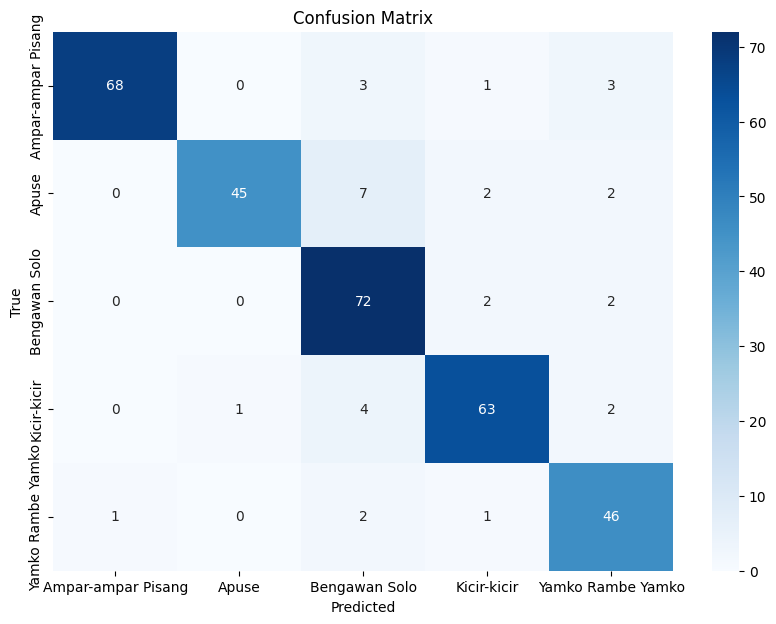

In [188]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### SVM - Supervised ML

In [189]:
from sklearn.svm import SVC

# Train an SVM model
svm_model = SVC(kernel='linear', random_state=42, C=len(model.classes_))
svm_model.fit(X_train, y_train)


SVC(C=5, kernel='linear', random_state=42)

In [190]:
# Evaluate the SVM model
print_score(svm_model, X_train, y_train, X_test, y_test, train=True)

Train Result:
Accuracy Score: 80.35%
F1 Score: 80.31%
Precision Score: 80.53%
Recall Score: 80.35%
_______________________________________________
CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

Ampar-ampar Pisang       0.81      0.87      0.84       210
             Apuse       0.88      0.84      0.86       238
     Bengawan Solo       0.76      0.84      0.80       326
       Kicir-kicir       0.83      0.74      0.78       266
 Yamko Rambe Yamko       0.77      0.73      0.75       268

          accuracy                           0.80      1308
         macro avg       0.81      0.81      0.81      1308
      weighted avg       0.81      0.80      0.80      1308

_______________________________________________
Confusion Matrix: 
 [[183   5   7   8   7]
 [  9 201  13   3  12]
 [  9  11 274  14  18]
 [ 12   6  30 197  21]
 [ 13   6  37  16 196]]



In [191]:

print_score(svm_model, X_train, y_train, X_test, y_test, train=False)

Test Result:
Accuracy Score: 75.84%
F1 Score: 75.88%
Precision Score: 77.23%
Recall Score: 75.84%
_______________________________________________
CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

Ampar-ampar Pisang       0.81      0.81      0.81        75
             Apuse       0.85      0.70      0.76        56
     Bengawan Solo       0.69      0.86      0.76        76
       Kicir-kicir       0.85      0.66      0.74        70
 Yamko Rambe Yamko       0.64      0.74      0.69        50

          accuracy                           0.76       327
         macro avg       0.77      0.75      0.75       327
      weighted avg       0.77      0.76      0.76       327

_______________________________________________
Confusion Matrix: 
 [[61  1  5  4  4]
 [ 4 39  6  2  5]
 [ 2  3 65  2  4]
 [ 4  1 11 46  8]
 [ 4  2  7  0 37]]



### Decision Tree's

In [192]:
from sklearn.tree import DecisionTreeClassifier

# Train a Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [193]:
# Evaluate the Decision Tree model on the training data
print_score(dt_model, X_train, y_train, X_test, y_test, train=True)

Train Result:
Accuracy Score: 100.00%
F1 Score: 100.00%
Precision Score: 100.00%
Recall Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

Ampar-ampar Pisang       1.00      1.00      1.00       210
             Apuse       1.00      1.00      1.00       238
     Bengawan Solo       1.00      1.00      1.00       326
       Kicir-kicir       1.00      1.00      1.00       266
 Yamko Rambe Yamko       1.00      1.00      1.00       268

          accuracy                           1.00      1308
         macro avg       1.00      1.00      1.00      1308
      weighted avg       1.00      1.00      1.00      1308

_______________________________________________
Confusion Matrix: 
 [[210   0   0   0   0]
 [  0 238   0   0   0]
 [  0   0 326   0   0]
 [  0   0   0 266   0]
 [  0   0   0   0 268]]



In [194]:
# Evaluate the Decision Tree model on the test data
print_score(dt_model, X_train, y_train, X_test, y_test, train=False)

Test Result:
Accuracy Score: 66.97%
F1 Score: 66.97%
Precision Score: 68.14%
Recall Score: 66.97%
_______________________________________________
CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

Ampar-ampar Pisang       0.82      0.63      0.71        75
             Apuse       0.67      0.57      0.62        56
     Bengawan Solo       0.66      0.79      0.72        76
       Kicir-kicir       0.63      0.64      0.64        70
 Yamko Rambe Yamko       0.58      0.70      0.64        50

          accuracy                           0.67       327
         macro avg       0.67      0.67      0.66       327
      weighted avg       0.68      0.67      0.67       327

_______________________________________________
Confusion Matrix: 
 [[47  5  6 11  6]
 [ 5 32  6  5  8]
 [ 1  3 60  5  7]
 [ 1  6 14 45  4]
 [ 3  2  5  5 35]]



# KNN

In [195]:
# knn
from sklearn.neighbors import KNeighborsClassifier

# Train a KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [196]:
print_score(knn_model, X_train, y_train, X_test, y_test, train=True)

Train Result:
Accuracy Score: 85.40%
F1 Score: 85.62%
Precision Score: 86.69%
Recall Score: 85.40%
_______________________________________________
CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

Ampar-ampar Pisang       0.68      0.91      0.78       210
             Apuse       0.85      0.84      0.84       238
     Bengawan Solo       0.90      0.89      0.90       326
       Kicir-kicir       0.93      0.85      0.89       266
 Yamko Rambe Yamko       0.92      0.78      0.85       268

          accuracy                           0.85      1308
         macro avg       0.86      0.85      0.85      1308
      weighted avg       0.87      0.85      0.86      1308

_______________________________________________
Confusion Matrix: 
 [[192   7   4   0   7]
 [ 26 199   5   4   4]
 [ 18   8 290   5   5]
 [ 21  11   6 226   2]
 [ 24  10  17   7 210]]



In [197]:
print_score(knn_model, X_train, y_train, X_test, y_test, train=False)

Test Result:
Accuracy Score: 77.98%
F1 Score: 78.08%
Precision Score: 78.98%
Recall Score: 77.98%
_______________________________________________
CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

Ampar-ampar Pisang       0.66      0.84      0.74        75
             Apuse       0.80      0.70      0.74        56
     Bengawan Solo       0.90      0.87      0.89        76
       Kicir-kicir       0.80      0.76      0.78        70
 Yamko Rambe Yamko       0.79      0.68      0.73        50

          accuracy                           0.78       327
         macro avg       0.79      0.77      0.78       327
      weighted avg       0.79      0.78      0.78       327

_______________________________________________
Confusion Matrix: 
 [[63  2  2  4  4]
 [10 39  1  3  3]
 [ 5  2 66  2  1]
 [ 9  5  2 53  1]
 [ 9  1  2  4 34]]

